# Maritime Choke Point Trends Monitor

The objective of this analysis is to examine the impact of the Red Sea Conflict on maritime trade statistics derived from AIS data.  

We process transit calls and estimated trade volume from the IMF's [PortWatch](https://portwatch.imf.org/) platform for key areas of interest, and then produce some charts to inspect trends and calculate percentage changes.

In [2]:
import os
import sys
from os.path import join, exists


import pandas as pd

import git

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")
sys.path.append(join(git_root, "src", "red-sea-monitoring"))
from utils import *

# For plotting
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, percent_format
import plotnine

plotnine.options.figure_size = (10, 8)

output_dir = r"C:\Users\WB514197\OneDrive - WBG\GOST_Deliverables\Red Sea\Data"
charts_dir = join(git_root, "reports")

## Locations

In [3]:
chokepoints = get_chokepoints()

In [3]:
# List areas of interest
aois = ["Bab el-Mandeb Strait", "Cape of Good Hope", "Suez Canal"]
chokepoints_sel = chokepoints.loc[chokepoints.portname.isin(aois)]
chokepoints_sel

,portid,portname,country,ISO3,continent,fullname,lat,lon,vessel_count_total,vessel_count_container,...,vessel_count_tanker,industry_top1,industry_top2,industry_top3,share_country_maritime_import,share_country_maritime_export,LOCODE,pageid,countrynoaccents,ObjectId
0,chokepoint1,Suez Canal,None,None,None,Suez Canal,30.593346,32.436882,22217,6455,...,6919,"Petroleum, Chemical and Non-Metallic Mineral P...",Mining and Quarrying,Agriculture,None,None,None,c57c79bf612b4372b08a9c6ea9c97ef0,None,1
3,chokepoint4,Bab el-Mandeb Strait,None,None,None,Bab el-Mandeb Strait,12.788597,43.349545,22519,6280,...,7386,"Petroleum, Chemical and Non-Metallic Mineral P...",Mining and Quarrying,Agriculture,None,None,None,6b1814d64903461b98144a6cc25eb79c,None,4
6,chokepoint7,Cape of Good Hope,None,None,None,Cape of Good Hope,-34.927286,20.882737,17332,2018,...,3973,Mining and Quarrying,"Petroleum, Chemical and Non-Metallic Mineral P...",Agriculture,None,None,None,edf18f455a2b4637a3632b6af201abe9,None,7


In [4]:
# chokepoints_sel.loc[:, "geometry"] = chokepoints_sel.apply(lambda x: Point(x.lon, x.lat), axis=1)
# chokepoints_sel = gpd.GeoDataFrame(chokepoints_sel, geometry='geometry', crs='EPSG:4326')

In [5]:
# chokepoints_sel.to_file(join(output_dir, "chokepoints.shp"), driver='ESRI Shapefile')

### Trade Data

In [10]:
ids = list(chokepoints_sel.portid)
ids

['chokepoint1', 'chokepoint4', 'chokepoint7']

In [11]:
df_chokepoints = get_chokepoint_data(ids)

In [12]:
df_chokepoints.loc[:, "ymd"] = df_chokepoints.date.dt.strftime("%Y-%m-%d")

In [13]:
# df_chokepoints.to_csv(join(out_dir, f'chokepoints_data_{time.strftime("%m_%d_%Y")}.csv'), index=False)

## Data Analysis

In [4]:
# df = pd.read_csv(join(output_dir, f'chokepoints_data_{time.strftime("%m_%d_%Y")}.csv'))
df = pd.read_csv(join(output_dir, "chokepoints_data_02_26_2024.csv"))
df.date = pd.to_datetime(df.date)

In [5]:
df = df.loc[df.date >= "2019-01-01"].copy()

In [7]:
df.tail(2)

,portid,portname,date,n_cargo,n_tanker,n_total,capacity,ObjectId,ymd
5629,chokepoint7,Cape of Good Hope,2024-02-18 19:00:00,61,17,78,5.976186e+06,20796,2024-02-18
5630,chokepoint7,Cape of Good Hope,2024-02-19 19:00:00,64,23,87,7.643016e+06,20797,2024-02-19


In [14]:
df = (
    df.groupby("portname")[["n_tanker", "n_cargo", "n_total", "capacity", "date"]]
    .rolling(7, center=True, min_periods=1, on="date")
    .mean()
)
df.reset_index(inplace=True)
df.drop("level_1", axis=1, inplace=True)
df.loc[:, "ymd"] = df.date.dt.strftime("%Y-%m-%d")
df.loc[:, "md"] = df.date.dt.strftime("%m-%d")

In [15]:
df.head(2)

,portname,capacity,n_cargo,n_tanker,n_total,date,ymd,md
0,Bab el-Mandeb Strait,4.149714e+06,42.0,18.25,60.25,2019-01-01 19:00:00,2019-01-01,01-01
1,Bab el-Mandeb Strait,4.129687e+06,40.6,18.20,58.80,2019-01-02 19:00:00,2019-01-02,01-02


### Plot Transit Calls Historical

In [16]:
start_reference_date = "2022-01-01"
conflict_date = "2023-10-07"
crisis_date = "2023-11-17"

In [ ]:
if not exists(join(charts_dir, "chokepoints")):
    os.makedirs(join(charts_dir, "chokepoints"), mode=0o777)

In [32]:
p0 = (
    ggplot(df, aes(x="date", y="n_total", group="portname", color="portname"))  #
    + geom_line(alpha=1, size=0.4)
    + geom_vline(xintercept=conflict_date, linetype="dashed", color="red")
    + geom_vline(xintercept=crisis_date, linetype="dashed", color="red")
    + labs(
        x="",
        y="Number of Vessels",
        title="AIS Transit Calls in Key Areas",
        color="Area of Interest",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_x_datetime(breaks=date_breaks("6 month"), labels=date_format("%Y-%m"))
    + scale_color_brewer(type="qual", palette=2)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme(legend_position="none")
    + facet_wrap("~portname", scales="fixed", ncol=1)
)
# p0
p0.save(
    filename=join(
        charts_dir, "chokepoints", "transit-calls-chokepoints-historical.jpeg"
    ),
    dpi=300,
)

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\chokepoints\transit-calls-chokepoints-historical.jpeg


Periods
- **Baseline**: 2021, 2022, 2023 (January 1st – October 6th)
- **Middle East Conflict**: 2023 (October 7th - November 16th)
- **Red Sea Crisis**: November 17th - January 31st, 2024

### Calculate Reference Values

In [18]:
start_reference_date = "2022-01-01"
conflict_date = "2023-10-07"
crisis_date = "2023-11-17"

In [19]:
df_ref = df.loc[(df.date >= start_reference_date) & (df.date < conflict_date)].copy()

In [20]:
df_ref = df_ref.groupby(["portname", "md"])[
    ["n_tanker", "n_cargo", "n_total", "capacity"]
].mean()

In [21]:
df_ref.reset_index(inplace=True)

In [22]:
df_ref.rename(
    columns={
        "n_tanker": "n_tanker_ref",
        "n_cargo": "n_cargo_ref",
        "n_total": "n_total_ref",
        "capacity": "capacity_ref",
    },
    inplace=True,
)

In [23]:
df_filt = df.loc[(df.date >= "2023-01-01")].copy()

In [24]:
df_filt = df_filt.merge(df_ref, on=["portname", "md"], how="left", validate="m:1")

In [25]:
df_filt.loc[:, "n_total_pct_ch"] = df_filt.apply(
    lambda x: (x.n_total - x.n_total_ref) / (x.n_total_ref), axis=1
)

In [26]:
# data types in pandas data frame
# df_filt.info()

In [29]:
p1 = (
    ggplot(df_filt, aes(x="ymd", y="n_total", group="portname", color="portname"))  #
    + geom_line(alpha=1)
    + geom_vline(xintercept=conflict_date, linetype="dashed", color="red")
    + geom_vline(xintercept=crisis_date, linetype="dashed", color="red")
    + labs(
        x="",
        y="Number of Vessels",
        title="AIS Transit Calls in Key Areas",
        color="Area of Interest",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + scale_color_brewer(type="qual", palette=2)
    + theme(legend_position="bottom")
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
# p1
p1.save(
    filename=join(charts_dir, "chokepoints", "transit-calls-chokepoints.jpeg"), dpi=300
)

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\chokepoints\transit-calls-chokepoints.jpeg


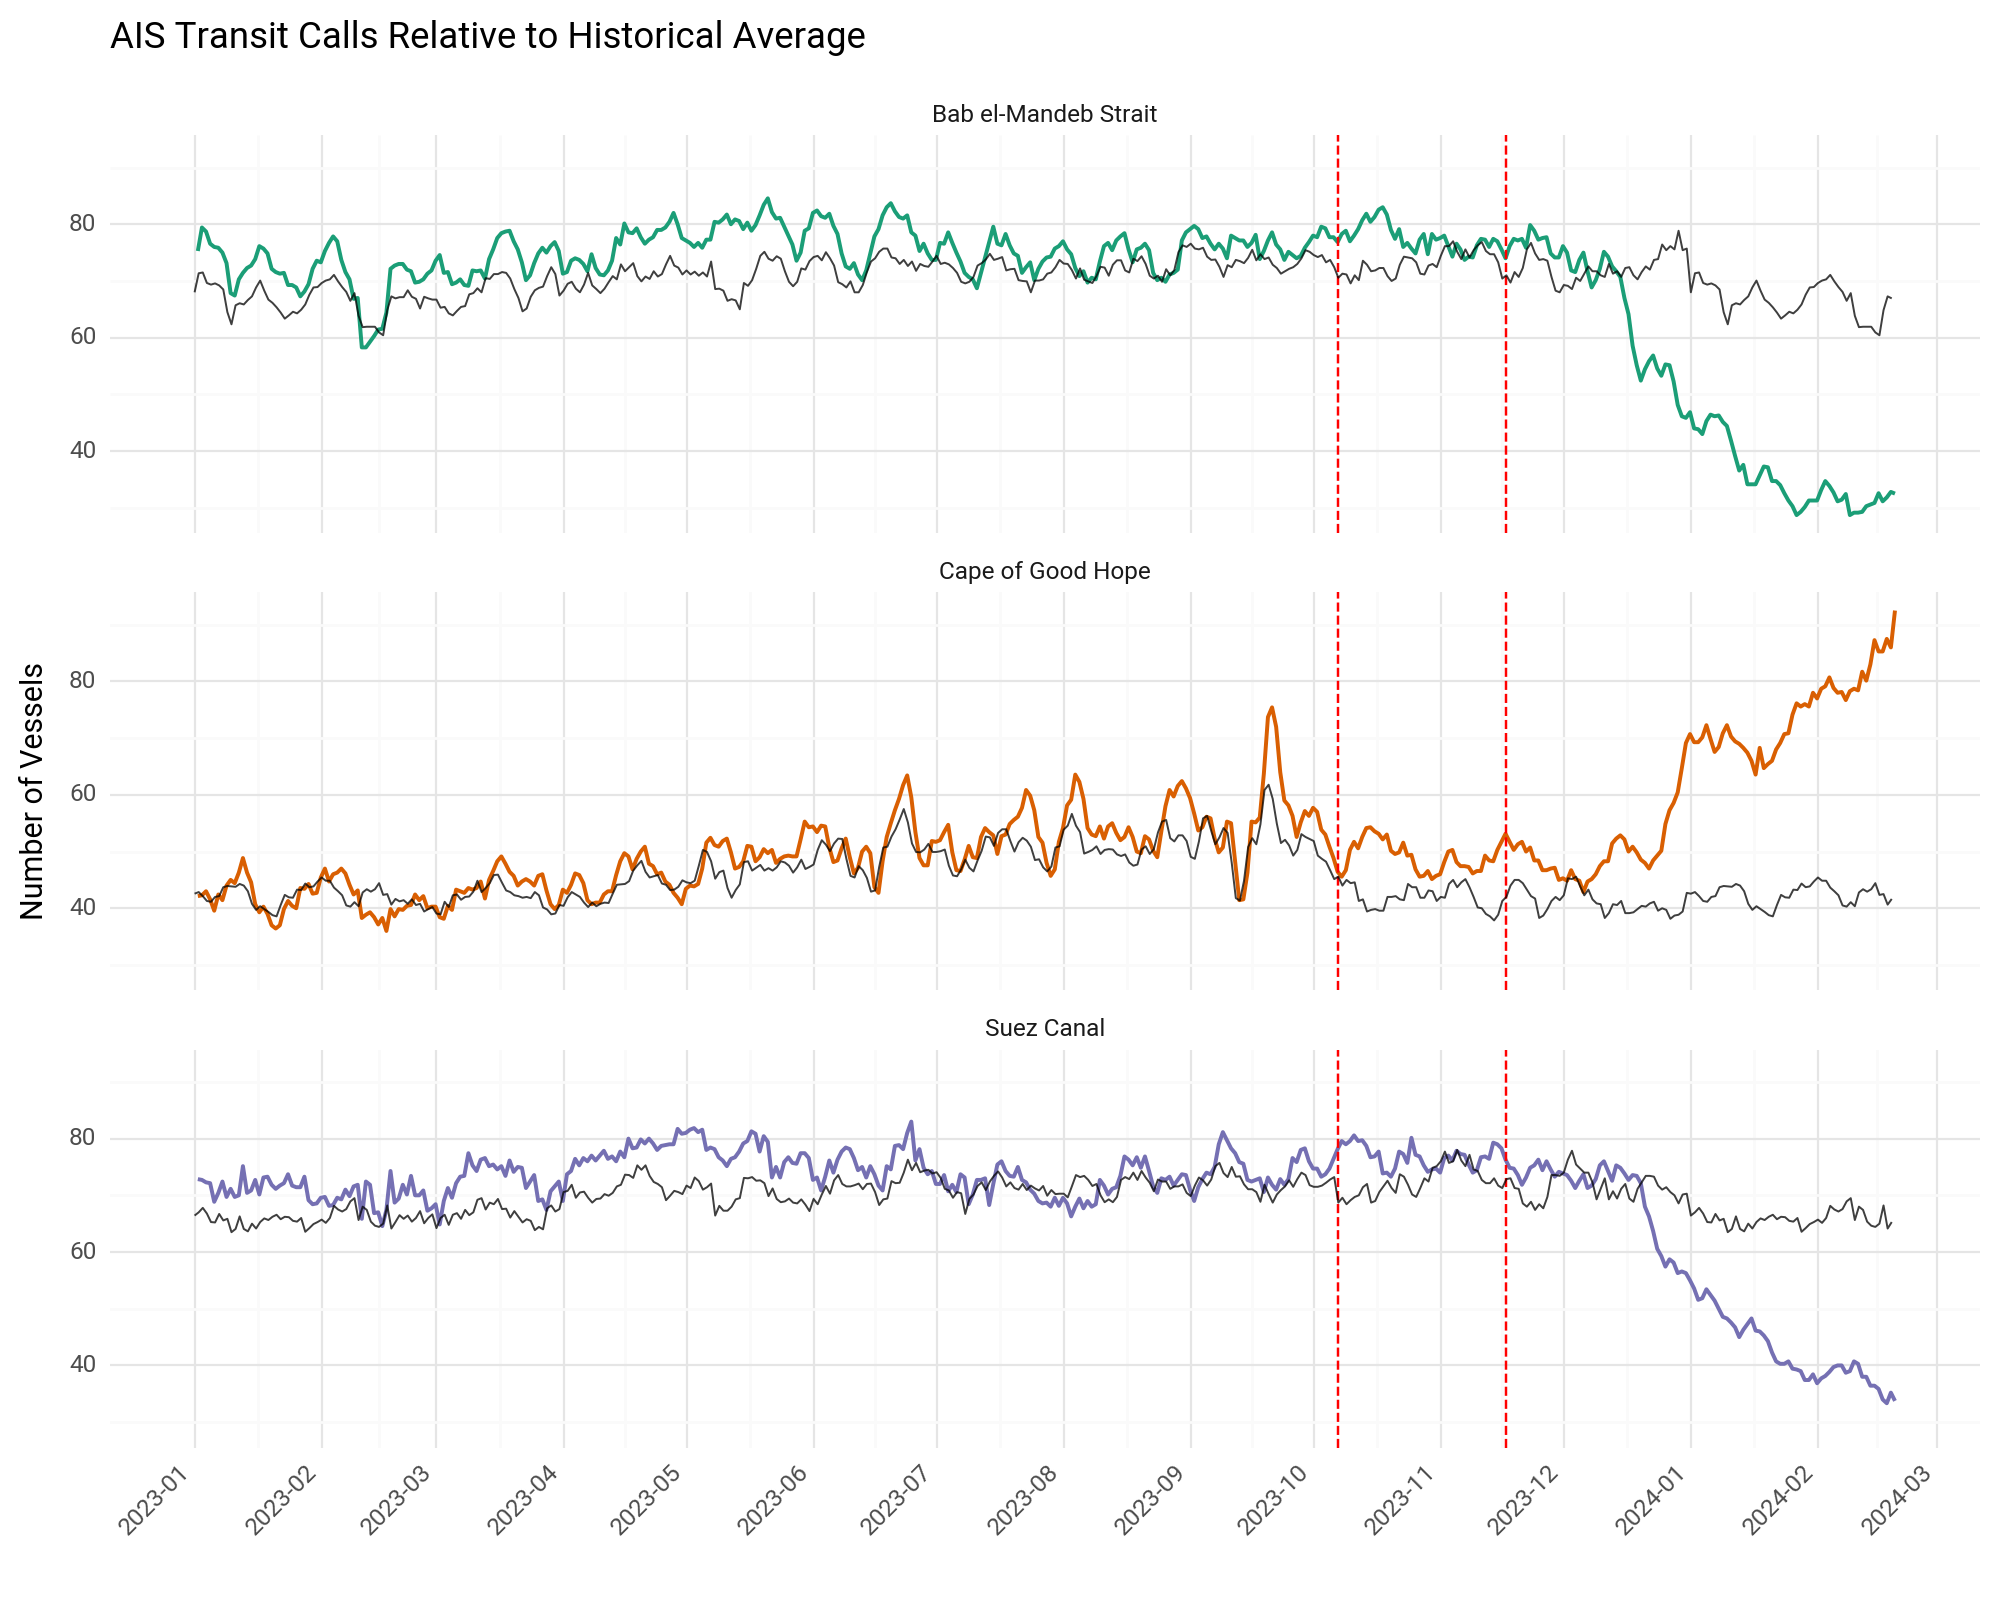

<Figure Size: (1000 x 800)>

In [28]:
p2 = (
    ggplot(df_filt, aes(x="date", y="n_total", group="portname", color="portname"))  #
    + geom_line(size=0.8)
    + geom_vline(xintercept=conflict_date, linetype="dashed", color="red")
    + geom_vline(xintercept=crisis_date, linetype="dashed", color="red")
    + geom_line(
        aes(x="date", y="n_total_ref", group="portname"),
        color="black",
        size=0.4,
        alpha=3 / 4,
    )
    + labs(
        x="",
        y="Number of Vessels",
        title="AIS Transit Calls Relative to Historical Average",
        color="Area of Interest",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + scale_color_brewer(type="qual", palette=2)
    # + scale_y_continuous(labels=comma_format())
    + theme(legend_position="none")
    + facet_wrap("~portname", scales="fixed", ncol=1)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
p2
p2.save(
    filename=join(charts_dir, "chokepoints", "transit-calls-chokepoints-ref.jpeg"),
    dpi=300,
)

In [36]:
# df_filt.loc[df_filt.date>="2023-08-01"]

In [38]:
p3 = (
    ggplot(
        df_filt.loc[df_filt.date >= "2023-08-01"],
        aes(x="ymd", y="n_total_pct_ch", group="portname", color="portname"),
    )  #
    + geom_line(size=0.8)
    + geom_vline(xintercept=conflict_date, linetype="dashed", color="red")
    + geom_vline(xintercept=crisis_date, linetype="dashed", color="red")
    + geom_hline(yintercept=0, color="black", alpha=3 / 4, size=0.3)
    + labs(
        x="",
        y="%",
        title="AIS Transit Calls in Key Areas, % Change",
        color="Area of Interest",
    )
    + theme_minimal()
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + scale_color_brewer(type="qual", palette=2)
    + scale_y_continuous(labels=percent_format())
    + theme(legend_position="none")
    + facet_wrap("~portname", scales="fixed", ncol=1)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
p3
p3.save(
    filename=join(charts_dir, "chokepoints", "transit-calls-chokepoints-pct.jpeg"),
    dpi=300,
)

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\chokepoints\transit-calls-chokepoints-pct.jpeg


## Summary


In [31]:
conflict_date, crisis_date

('2023-10-07', '2023-11-17')

In [32]:
df.loc[:, "period"] = ""

In [33]:
df.loc[
    (df.date >= start_reference_date) & (df.date < crisis_date), "period"
] = "Reference"
df.loc[
    (df.date >= conflict_date) & (df.date < crisis_date), "period"
] = "Middle East Conflict"
df.loc[(df.date >= crisis_date), "period"] = "Red Sea Crisis"

In [34]:
df_agg = (
    df.loc[df.period != ""]
    .groupby(["portname", "period"])[["n_tanker", "n_cargo", "n_total", "capacity"]]
    .mean()
)

In [35]:
# change order of rows
df_agg = df_agg.reindex(
    ["Reference", "Middle East Conflict", "Red Sea Crisis"], level=1
)

In [37]:
table = df_agg.copy()
# format column numbers to 2 decimal places only for first three columns
# df_agg = df_agg.applymap(lambda x: "{:.2f}".format(x))
table.iloc[:, :3] = table.iloc[:, :3].applymap(lambda x: "{:.2f}".format(x))

# format last column numbers to thousands
table.loc[:, "capacity"] = table.capacity.apply(lambda x: "{:,.0f}".format(x))

table.rename(
    columns={
        "n_tanker": "Tankers",
        "n_cargo": "Cargo",
        "n_total": "Total",
        "capacity": "Capacity",
    },
    inplace=True,
)
table
# table.transpose()

C:\Users\WB514197\AppData\Local\Temp\ipykernel_25028\2809735210.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


Tankers  Cargo  Total   Capacity
portname             period                                               
Bab el-Mandeb Strait Reference              23.91  46.86  70.77  4,823,326
                     Middle East Conflict   25.95  51.58  77.53  5,305,603
                     Red Sea Crisis         17.98  32.14  50.12  3,106,581
Cape of Good Hope    Reference               9.34  36.68  46.01  4,380,133
                     Middle East Conflict   10.03  39.20  49.23  4,813,646
                     Red Sea Crisis         13.90  49.31  63.21  5,735,754
Suez Canal           Reference              23.09  46.98  70.07  4,737,291
                     Middle East Conflict   25.20  51.64  76.83  5,246,677
                     Red Sea Crisis         18.38  36.99  55.38  3,476,979

In [2]:
df_agg_copy = df_agg.copy()

NameError: name 'df_agg' is not defined

In [120]:
res = []
for aoi in aois:
    df_sub = df_agg_copy.loc[(aoi), :].transpose().copy()
    df_sub.loc[:, "Middle East Conflict"] = (
        df_sub.loc[:, "Middle East Conflict"] - df_sub.loc[:, "Reference"]
    ) / df_sub.loc[:, "Reference"]
    df_sub.loc[:, "Red Sea Crisis"] = (
        df_sub.loc[:, "Red Sea Crisis"] - df_sub.loc[:, "Reference"]
    ) / df_sub.loc[:, "Reference"]
    df_sub2 = df_sub.transpose()
    df_sub2.drop("Reference", inplace=True)
    df_sub2.loc[:, "portname"] = aoi
    res.append(df_sub2)

In [130]:
df_agg_pct = pd.concat(res)

In [131]:
df_agg_pct.reset_index(inplace=True)
df_agg_pct.set_index(["portname", "period"], inplace=True)

# format columns as pct
df_agg_pct = df_agg_pct.applymap(lambda x: "{:.2%}".format(x))
df_agg_pct.rename(
    columns={
        "n_tanker": "Tankers",
        "n_cargo": "Cargo",
        "n_total": "Total",
        "capacity": "Capacity",
    },
    inplace=True,
)
df_agg_pct

C:\Users\WB514197\AppData\Local\Temp\ipykernel_25028\3300185501.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


Tankers    Cargo    Total Capacity
portname             period                                                  
Bab el-Mandeb Strait Middle East Conflict    8.56%   10.08%    9.56%   10.00%
                     Red Sea Crisis        -24.79%  -31.42%  -29.18%  -35.59%
Cape of Good Hope    Middle East Conflict    7.42%    6.87%    6.98%    9.90%
                     Red Sea Crisis         48.88%   34.45%   37.38%   30.95%
Suez Canal           Middle East Conflict    9.12%    9.91%    9.65%   10.75%
                     Red Sea Crisis        -20.38%  -21.25%  -20.97%  -26.60%